# **Gender prediction with BERT on PAN**

---



### Installing and importing dependencies

In [1]:
!pip install transformers==3
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import pandas as pd
from transformers import BertForSequenceClassification

### Loading data

In [2]:
# Loading files from drive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Language, speech and dialogue processing/Datasets/df_pan_train.csv', index_col=None) 
df = df.drop(['Unnamed: 0', 'lang', 'id', 'age_group'], axis=1)
df = df.sample(100000)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = df.groupby('gender').apply(lambda x: x.sample(frac=0.2))

In [4]:
df = df.reset_index(drop=True)
df

,gender,text
0,female,"A crowded bus Summer day in, day really makes ..."
1,female,Selecting the Right Light Fixtures<br />;<br /...
2,female,My spouse and i known as service and also had ...
3,female,"<img class=""smiley"" src=""http://www.pan.net/sm..."
4,female,"Once you glance through a catalog, it?s remark..."
...,...,...
19995,male,Audio instruments stores likewise sell recordi...
19996,male,"On the web <a href=""http://en.pan.netcom/go/ou..."
19997,male,1. give me ur number?\n<br />;2. love me?\n<br...
19998,male,WHY PEOPLE LOOK BRIGHTER AT NIGHT THAN DURING ...


In [5]:
fm = df["gender"].unique().tolist()
fm.sort()
fm_dict = {}
for gender in fm:
  fm_dict[gender] = df.loc[df['gender'] == gender]

for key, value in fm_dict.items():
  fm_dict[key] = value
  
print(fm_dict)

{'female':       gender                                               text
0     female  A crowded bus Summer day in, day really makes ...
1     female  Selecting the Right Light Fixtures<br />;<br /...
2     female  My spouse and i known as service and also had ...
3     female  <img class="smiley" src="http://www.pan.net/sm...
4     female  Once you glance through a catalog, it?s remark...
...      ...                                                ...
9902  female  <p>;<img border="0" style="width: 258px; heigh...
9903  female  However when it is a plumber in Calgary is on ...
9904  female  The Monster from the united states can always ...
9905  female  Clustered surrounding the stems collection of ...
9906  female  Doing this to go for winning bets surrounding ...

[9907 rows x 2 columns], 'male':       gender                                               text
9907    male  <a href="http://en.pan.netcom/go/out/url=http%...
9908    male  If you are looking for beginners Pilates clas

In [6]:
dataframes_f = []
dataframes_m = []

for key, value in fm_dict.items():
  if key == 'female':
    dataframes_f.append(value)
  elif key == 'male':
    dataframes_m.append(value)


df_f = pd.concat(dataframes_f)
df_m = pd.concat(dataframes_m)


all_dataframes = [df_f, df_m]

min_len = len(all_dataframes[0])

for df in all_dataframes:
  if len(df) < min_len:
    min_len = len(df)

all_dataframes = [df_f.sample(min_len), df_m.sample(min_len)]

df = pd.concat(all_dataframes)

In [7]:
df.head()

,gender,text
7381,female,Eyelash extensions are a relatively new beauty...
7359,female,If you want to grow your business and take it ...
1657,female,The real cause of your husband's affair seriou...
4346,female,Your skin quality is very important. It is one...
2923,female,"<center>;<img src=""<a href=""http://en.pan.netc..."


In [8]:
df['gender'].value_counts()

male      9907
female    9907
Name: gender, dtype: int64

In [9]:
possible_labels = df.gender.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'female': 0, 'male': 1}

In [11]:
df['label'] = df.gender.replace(label_dict)


In [12]:
df.head()

,gender,text,label
7381,female,Eyelash extensions are a relatively new beauty...,0
7359,female,If you want to grow your business and take it ...,0
1657,female,The real cause of your husband's affair seriou...,0
4346,female,Your skin quality is very important. It is one...,0
2923,female,"<center>;<img src=""<a href=""http://en.pan.netc...",0


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [14]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [15]:
df.head()

,gender,text,label,data_type
7381,female,Eyelash extensions are a relatively new beauty...,0,train
7359,female,If you want to grow your business and take it ...,0,val
1657,female,The real cause of your husband's affair seriou...,0,train
4346,female,Your skin quality is very important. It is one...,0,train
2923,female,"<center>;<img src=""<a href=""http://en.pan.netc...",0,val


In [16]:
df.groupby(['gender', 'label', 'data_type']).count()

text
gender label data_type      
female 0     train      8420
             val        1487
male   1     train      8421
             val        1486

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [18]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


In [19]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [20]:
len(dataset_train), len(dataset_val)

(16841, 2973)

In [21]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [23]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [24]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [25]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    total = 0
    correct = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])/ len(y_true)}\n')

        correct += len(y_preds[y_preds==label])
        total += len(y_true)

    print(f'Overall Accuracy: {correct/total}\n')
    return preds_flat, labels_flat

In [26]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [28]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [29]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Language, speech and dialogue processing/Bert_models/BERT_gender_PAN_full_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.7020573291461749
Validation loss: 0.694825193264891
F1 Score (Weighted): 0.3331464831083851



Epoch 2
Training loss: 0.6987463356943626
Validation loss: 0.6933217313287237
F1 Score (Weighted): 0.42161558120444387



Epoch 3
Training loss: 0.6921912893668841
Validation loss: 0.6813680973170865
F1 Score (Weighted): 0.5576197088973835



Epoch 4
Training loss: 0.6797296481613783
Validation loss: 0.689330654055271
F1 Score (Weighted): 0.5620719653513851



Epoch 5
Training loss: 0.6568162798928644
Validation loss: 0.7094351232773601
F1 Score (Weighted): 0.5725948405230147



In [30]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [31]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Language, speech and dialogue processing/Bert_models/BERT_gender_PAN_full_epoch_5.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [32]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [33]:
predictions, true_vals = accuracy_per_class(predictions, true_vals)



Class: female
Accuracy: 0.667787491593813

Class: male
Accuracy: 0.4845222072678331

Overall Accuracy: 0.5761856710393541



**Confusion Matrix**

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Language, speech and dialogue processing/GENDER_PAN_BERT_confusion_matrix.png')

Normalized confusion matrix
[[0.67 0.33]
 [0.52 0.48]]


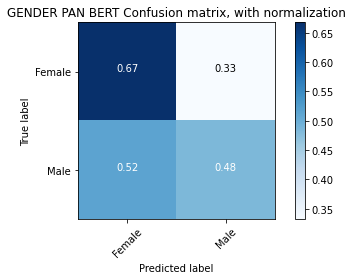

In [35]:

conf_matrix = confusion_matrix(np.array(true_vals), np.array(predictions), labels=[0, 1])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix(conf_matrix, classes=['Female', 'Male'], normalize=True, title='GENDER PAN BERT Confusion matrix, with normalization')